### Assignment 1
### Student ID: 34116478
### Student Name: Qi Zhou

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import zero_one_loss, log_loss
from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
# from sklearn.linear_model import LogisticRegression


# S3.  Ridge Regression and Logistic Regression versus Bayes Classifier

## Question 5: Discriminative vs Generative Models

# 5.1 Perform a training/test split (with train size equal to 0.8) and report which of the models performs best in terms of train and test performance.

In [2]:
breast_cancer = load_breast_cancer()
x_train, x_test, y_train, y_test = train_test_split(breast_cancer.data, breast_cancer.target, train_size=0.8, random_state=36)


# lr_pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, solver='sag'))

lr_pipeline = make_pipeline(StandardScaler(), 
                            LogisticRegression(random_state=0, max_iter=500000, solver='saga', C=0.1))

lr_pipeline.fit(x_train, y_train)

train_accuracy = accuracy_score(y_train, lr_pipeline.predict(x_train))
test_accuracy = accuracy_score(y_test, lr_pipeline.predict(x_test))

print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

Training Accuracy: 0.9802197802197802
Testing Accuracy: 0.9824561403508771


## Bayesian Classifier Formulations

The Bayesian Classifier (BC) in the code is implemented with variations in the assumption of shared covariance matrices and conditional independence. The relevant mathematical formulations include:

### 1. **Class Conditional Density**
Given input data \(x\) and a class \(c\), the class-conditional density is assumed to be Gaussian:
$$
p(x \mid c) = \frac{1}{\sqrt{(2\pi)^k \det(\Sigma_c)}} \exp\left(-\frac{1}{2} (x - \mu_c)^T \Sigma_c^{-1} (x - \mu_c)\right)
$$
where \( \mu_c \) and \( \Sigma_c \) are the mean and covariance matrix for class \(c\), and \(k\) is the dimensionality of \(x\).

### 2. **Class Priors**
The class prior probabilities are estimated from the data:
$$
p(c) = \frac{\text{Number of samples in class } c}{\text{Total number of samples}}
$$

### 3. **Predictive Distribution**
Using Bayes' theorem, the predictive distribution for a new sample \(x\) is:
$$
p(c \mid x) = \frac{p(x \mid c) p(c)}{\sum_{c'} p(x \mid c') p(c')}
$$

### 4. **Decision Function**
For binary classification, the decision function is often computed as the log-ratio of the posterior probabilities:
$$
\text{decision\_function}(x) = \log\left(\frac{p(c=1 \mid x)}{p(c=0 \mid x)}\right)
$$
For multi-class problems, it's extended to:
$$
\text{decision\_function}_{c}(x) = \log\left(\frac{p(c \mid x)}{1 - p(c \mid x)}\right)
$$

### 5. **Covariance Matrix Configurations**
- **Full Covariance**: Each class has its own covariance matrix.
- **Shared Covariance**: All classes share the same covariance matrix.
- **Diagonal Covariance (Naive Bayes)**: Each feature is assumed conditionally independent, and thus the covariance matrix is diagonal.

## Logistic Regression Formulation

Logistic Regression is a discriminative model used in the code for comparison:
$$
\text{Log-odds} = X\beta
$$
$$
p(y = 1 \mid x) = \frac{1}{1 + \exp(-X\beta)}
$$
where \(X\) is the input feature matrix, \( \beta \) is the coefficient vector, and \(y\) is the binary target variable.

## Experiment Design

### Objective
The goal is to compare the Bayesian classifier's different configurations and logistic regression in terms of performance (training and testing errors) using the breast cancer dataset.

### Methodology
- **Data Splitting**: The data is split into training and testing sets with 80% of data for training.
- **Model Training**: Each model is trained on the training set.
- **Performance Evaluation**: The performance is evaluated based on the mean squared error (MSE) between the predicted and actual class labels on both training and testing sets.

### Comparative Analysis
For each variant of the Bayesian classifier and the logistic regression model, calculate and compare the following:
- Training error
- Testing error
- Logarithmic loss (for probabilistic predictions)
- Zero-one loss (for label predictions)

This analysis helps in determining which model configuration performs best in terms of both train and test performance on the breast cancer dataset.


In [3]:
class BayesianClassifier:
    def __init__(self, shared_cov=True, cond_ind=True):
        """
        Initialize the Bayesian Classifier.

        Parameters:
        shared_cov (bool): Whether to use a shared covariance matrix. If True, all classes share a single covariance matrix.
        cond_ind (bool): Conditional independence assumption. If True, assumes features are independent, resulting in a diagonal covariance matrix.
        """
        self.shared_cov = shared_cov
        self.cond_ind = cond_ind

    def fit(self, x, y):
        """
        Fit the model using the given input data x and labels y.

        Parameters:
        x (array-like): Input feature data.
        y (array-like): Corresponding labels.

        Returns:
        self: Returns the trained model instance.
        """
        self.classes_, class_counts = np.unique(y, return_counts=True)
        self.n_, self.p_ = x.shape
        self.k_ = len(self.classes_)
        self.cond_means_ = np.zeros((self.k_, self.p_))
        self.cond_covs_ = np.zeros((self.k_, self.p_, self.p_))

        self.class_priors_ = class_counts / self.n_  # Calculate the prior probability for each class

        for idx, class_label in enumerate(self.classes_):
            c_rows = (y == class_label)
            self.cond_means_[idx, :] = np.mean(x[c_rows], axis=0)  # Calculate the conditional mean for each class

            if self.cond_ind:
                # Independent features, use a diagonal covariance matrix
                variances = np.var(x[c_rows], axis=0)
                self.cond_covs_[idx] = np.diag(variances)
            else:
                # Dependent features, calculate the full covariance matrix
                self.cond_covs_[idx] = np.cov(x[c_rows].T, bias=True)

        if self.shared_cov:
            # Use a shared covariance matrix
            weighted_covs = np.average(self.cond_covs_, axis=0, weights=self.class_priors_)
            self.cond_covs_[:] = weighted_covs  # Apply the shared covariance to all classes

        return self

    def predict_proba(self, x):
        m = x.shape[0]
        cond_probs = np.zeros((m, self.k_))
        for idx in range(self.k_):
            cond_probs[:, idx] = multivariate_normal.pdf(x, self.cond_means_[idx], self.cond_covs_[idx], allow_singular=True)
        # Ensure class_priors_ is correctly broadcasted
        marginal_probs = np.sum(cond_probs * self.class_priors_[np.newaxis, :], axis=1, keepdims=True) + 1e-6  # Stability term
        probs = cond_probs * self.class_priors_[np.newaxis, :] / marginal_probs
        return probs

    def predict(self, x):
        """
        Predict class labels for the input data x.

        Parameters:
        x (array-like): Input data.

        Returns:
        array: Predicted class labels.
        """
        return self.classes_[np.argmax(self.predict_proba(x), axis=1)]

    def decision_function(self, x):
        """
        Compute the decision function values for comparing class probabilities in binary or multi-class problems.

        Parameters:
        x (array-like): Input data.

        Returns:
        array: Decision function values.
        """
        probs = self.predict_proba(x)
        if self.k_ == 2:
            return np.log(probs[:, 1] / probs[:, 0])
        else:
            return np.log(probs / (1 - probs))

    def generate(self, n, c, random_state=None):
        """
        Generate sample data for a given class.

        Parameters:
        n (int): Number of samples to generate.
        c (int): Class label.
        random_state (int, optional): Seed for the random number generator.

        Returns:
        array: Generated sample data.
        """
        class_idx = np.where(self.classes_ == c)[0][0]
        return multivariate_normal.rvs(self.cond_means_[class_idx], self.cond_covs_[class_idx], size=n, random_state=random_state)

In [4]:
# Apply StandardScaler to normalize the data for both Logistic Regression and Bayesian Classifier
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Train models using the normalized data
bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False).fit(x_train_scaled, y_train)
bc = BayesianClassifier(shared_cov=False, cond_ind=False).fit(x_train_scaled, y_train)
lr = lr_pipeline.fit(x_train_scaled, y_train)

# # Create classifier instances and train them
# bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False).fit(x_train, y_train)

# bc = BayesianClassifier(shared_cov=False, cond_ind=False).fit(x_train, y_train)
# lr = LogisticRegression(random_state=0).fit(x_train, y_train)  # Modified

# Put models into a list for iteration
models = [bc_shared, bc, lr]  # Modified
model_names = ['BC (shared)', 'BC', 'LR']  # Modified

# Output the training and testing error rates for each model
for model, name in zip(models, model_names):
    print(name, "----->", "train_error:", zero_one_loss(y_train, model.predict(x_train)))
    print(name, "----->", "test_error:", zero_one_loss(y_test, model.predict(x_test)))
    print(zero_one_loss(y_test, model.predict(x_test)))
    print("---------------------------------------------")

BC (shared) -----> train_error: 0.6197802197802198
BC (shared) -----> test_error: 0.6578947368421053
0.6578947368421053
---------------------------------------------
BC -----> train_error: 0.6197802197802198
BC -----> test_error: 0.6578947368421053
0.6578947368421053
---------------------------------------------
LR -----> train_error: 0.6197802197802198
LR -----> test_error: 0.6578947368421053
0.6578947368421053
---------------------------------------------


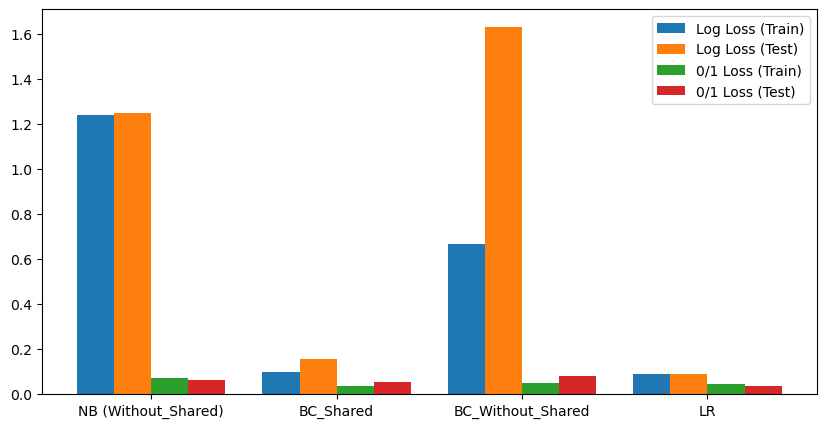

In [5]:
def plot_model_performances(models, model_names, x_train, y_train, x_test, y_test):
    """
    Plot the classification performance of different models on the training and test sets.
    
    Parameters:
    models (list): List of fitted models.
    model_names (list): List of corresponding model names.
    x_train (array): Features of the training data.
    y_train (array): Target labels of the training data.
    x_test (array): Features of the test data.
    y_test (array): Target labels of the test data.
    """
    # Initialize lists to store loss data
    losses = {'train_01': [], 'train_log': [], 'test_01': [], 'test_log': []}

    # Calculate training and test losses for each model
    for model in models:
        y_train_pred = model.predict(x_train)
        y_train_proba = model.predict_proba(x_train)
        y_test_pred = model.predict(x_test)
        y_test_proba = model.predict_proba(x_test)

        losses['train_01'].append(zero_one_loss(y_train, y_train_pred))
        losses['train_log'].append(log_loss(y_train, y_train_proba))
        losses['test_01'].append(zero_one_loss(y_test, y_test_pred))
        losses['test_log'].append(log_loss(y_test, y_test_proba))

    # Set up the plotting parameters
    xx = np.arange(len(models))
    bar_width = 0.2
    plt.figure(figsize=(10, 5))  # Set the size of the plot

    # Plot the bar chart
    plt.bar(xx - 1.5 * bar_width, losses['train_log'], width=bar_width, label='Log Loss (Train)')
    plt.bar(xx - 0.5 * bar_width, losses['test_log'], width=bar_width, label='Log Loss (Test)')
    plt.bar(xx + 0.5 * bar_width, losses['train_01'], width=bar_width, label='0/1 Loss (Train)')
    plt.bar(xx + 1.5 * bar_width, losses['test_01'], width=bar_width, label='0/1 Loss (Test)')

    # Set the x-axis and legend
    plt.xticks(xx, model_names)
    plt.legend()
    plt.show()

# The following part remains unchanged and is responsible for initializing models and calling the plot function

# Note that here it is assumed that BayesianClassifier has been defined, and relevant libraries have been imported

# Model initialization and fitting
# Example initialization code, needs to be adjusted to correct model initialization
nb_withoutShared = BayesianClassifier(shared_cov=False, cond_ind=True).fit(x_train, y_train)
bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False).fit(x_train, y_train)
bc_withoutShared = BayesianClassifier(shared_cov=False, cond_ind=False).fit(x_train, y_train)
lr = LogisticRegression(solver='lbfgs', max_iter=5000, random_state=0).fit(x_train, y_train)

# Model list and names
models = [nb_withoutShared, bc_shared, bc_withoutShared, lr]
model_names = ['NB (Without_Shared)', 'BC_Shared', 'BC_Without_Shared', 'LR']

# Call the plot function
plot_model_performances(models, model_names, x_train, y_train, x_test, y_test)


# 5.2 Implement an experiment

In [6]:
# Create an empty DataFrame to store model performance results
df = pd.DataFrame(columns=["model", "train_size", "log_error_train", "log_error_test",\
                           "zeroone_error_train", "zeroone_error_test"])
count = 0

# Loop through different training set sizes and train models on resampled training data
for n in range(5, 505, 5):
    for _ in range(10):  # Inner loop repeats 10 times
        x_train, x_test, y_train, y_test = train_test_split(breast_cancer.data, breast_cancer.target, train_size=n, random_state=36, shuffle=True)

    # Initialize different configurations of Bayesian classifiers and logistic regression models and train them
    nb_shared = BayesianClassifier(shared_cov=False, cond_ind=True).fit(x_train, y_train)
    bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False).fit(x_train, y_train)
    bc = BayesianClassifier(shared_cov=False, cond_ind=False).fit(x_train, y_train)
    lr = LogisticRegression(solver='lbfgs', max_iter=5000, random_state=0).fit(x_train, y_train)
    
    # Create a list of models and a corresponding list of model names
    models = [nb_withoutShared, bc_shared, bc_withoutShared, lr]
    model_names = ['NB (Without_Shared)', 'BC_shared', 'BC_Without_Shared', 'LR']
    
    # Evaluate the performance of each model on the training and test sets
    for model, name in zip(models, model_names):
        df.at[count, "model"] = name
        df.at[count, "train_size"] = n
        df.at[count, "log_error_train"] = log_loss(y_train, model.predict(x_train))
        df.at[count, "log_error_test"] = log_loss(y_test, model.predict(x_test))
        df.at[count, "zeroone_error_train"] = zero_one_loss(y_train, model.predict(x_train))
        df.at[count, "zeroone_error_test"] = zero_one_loss(y_test, model.predict(x_test))
        count += 1

In [7]:
df

,model,train_size,log_error_train,log_error_test,zeroone_error_train,zeroone_error_test
0,NB (Without_Shared),5,7.208731,2.428473,0.2,0.067376
1,BC_shared,5,0.0,22.687051,0.0,0.629433
2,BC_Without_Shared,5,7.208731,1.981123,0.2,0.054965
3,LR,5,0.0,4.217874,0.0,0.117021
4,NB (Without_Shared),10,3.604365,2.450195,0.1,0.067979
...,...,...,...,...,...,...
395,LR,495,1.529125,0.974153,0.042424,0.027027
396,NB (Without_Shared),500,2.595143,1.567115,0.072,0.043478
397,BC_shared,500,1.369659,1.044744,0.038,0.028986
398,BC_Without_Shared,500,2.018445,2.089487,0.056,0.057971


# 5.3 Create suitable plots that compare the mean train and test performances of all models as afunction of training size. 

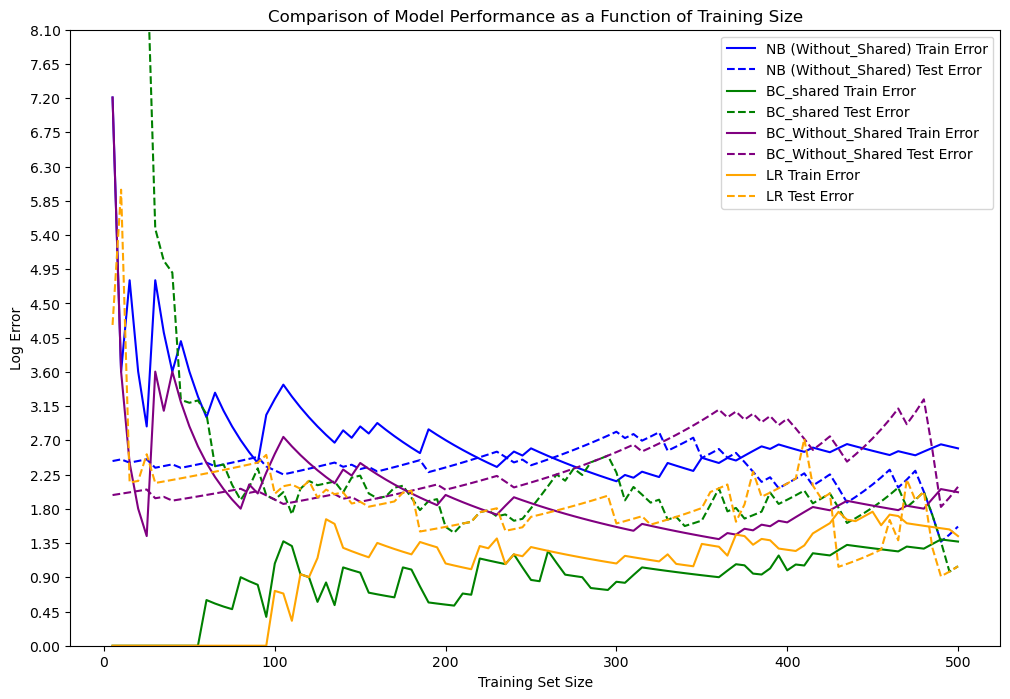

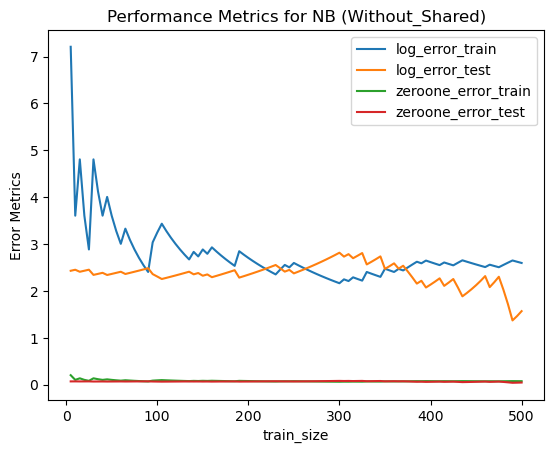

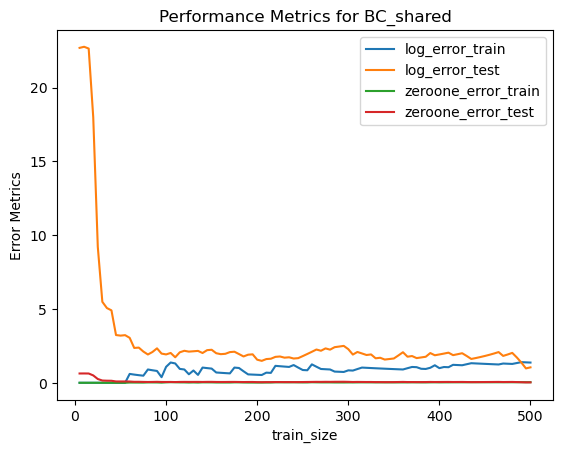

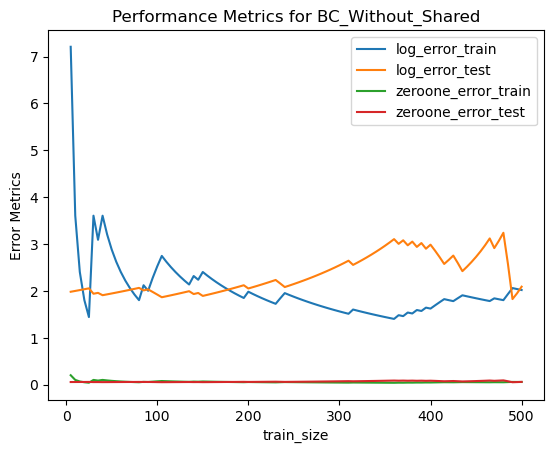

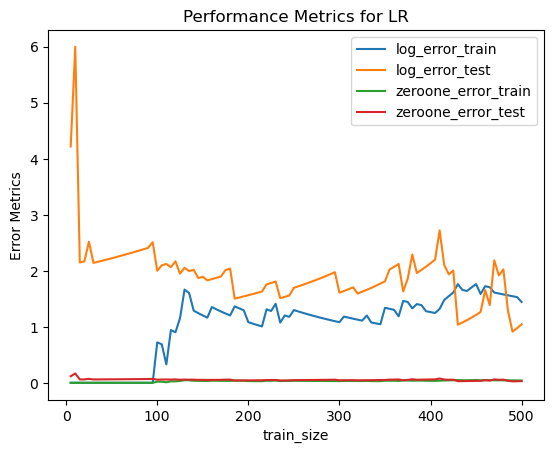

In [8]:
# Assign different colors to each model
colors = {
    'NB (Without_Shared)': 'blue',
    'BC_shared': 'green',
    'BC_Without_Shared': 'purple',
    'LR': 'orange'
}

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate through all models, plotting training and testing errors
for model in model_names:
    df_filtered = df[df.model == model]
    
    # Plot training error (solid line)
    plt.plot(df_filtered['train_size'], df_filtered['log_error_train'], linestyle='-', label=f'{model} Train Error', color=colors[model])
    
    # Plot testing error (dashed line)
    plt.plot(df_filtered['train_size'], df_filtered['log_error_test'], linestyle='--', label=f'{model} Test Error', color=colors[model])

# Set X and Y axis labels
plt.xlabel('Training Set Size')
plt.ylabel('Log Error')
# Adjust the Y-axis limits and ticks to better distinguish the lines
plt.ylim(0, 7)  # Set the Y-axis limit to focus on the most relevant range
plt.yticks(np.arange(0, 8.25, 0.45))  # Set Y-axis ticks with a 0.25 interval

# Add legend
plt.legend()

# Set plot title
plt.title('Comparison of Model Performance as a Function of Training Size')

# Display the plot
plt.show()

for model in model_names:
    df[df.model == model][["train_size", "log_error_train", "log_error_test", "zeroone_error_train", "zeroone_error_test"]].set_index(["train_size"]).plot()
    plt.ylabel('Error Metrics')  # Add y-axis label
    plt.title(f'Performance Metrics for {model}')  # Optional: Add title for each model's plot
    plt.show()  # Display the plot

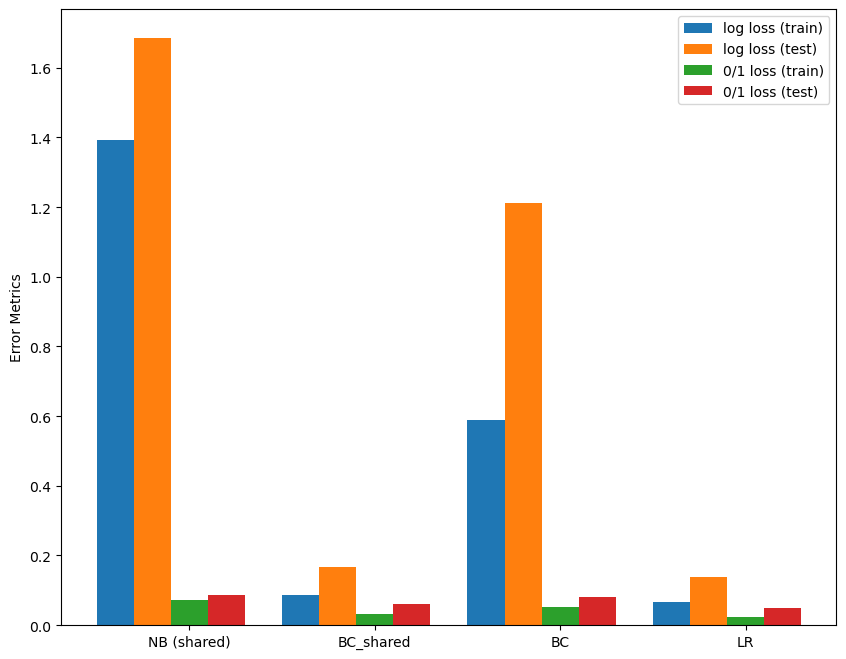

In [9]:
def plot_3(train_size):
    """
    Plots a comparison of model performances given a specific training set size.
    
    Parameters:
    train_size (int): The specified size of the training set.
    """
    # Initialize lists to store 0/1 loss and log loss for each model on the training and test sets
    train_01_losses = []
    train_log_losses = []
    test_01_losses = []
    test_log_losses = []

    # Load the data and split it according to the specified training set size
    x_train, x_test, y_train, y_test = train_test_split(load_breast_cancer().data, load_breast_cancer().target, train_size=train_size, random_state=80, shuffle=True)
    
    # Initialize and train models
    nb_shared = BayesianClassifier(shared_cov=False, cond_ind=True).fit(x_train, y_train)
    bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False).fit(x_train, y_train)
    bc = BayesianClassifier(shared_cov=False, cond_ind=False).fit(x_train, y_train)
    lr = LogisticRegression(solver='lbfgs', max_iter=5000, random_state=0).fit(x_train, y_train)
    
    models = [nb_shared, bc_shared, bc, lr]
    model_names = ['NB (shared)', 'BC_shared', 'BC', 'LR']
    
    # Evaluate each model's performance
    for i, model in enumerate(models):
        train_01_losses.append(zero_one_loss(y_train, model.predict(x_train)))
        train_log_losses.append(log_loss(y_train, model.predict_proba(x_train)))
        test_01_losses.append(zero_one_loss(y_test, model.predict(x_test)))
        test_log_losses.append(log_loss(y_test, model.predict_proba(x_test)))
        
    # Plot bar charts to compare model performances
    xx = np.arange(len(models))  # Model indices
    bar_width = 1 / (len(models) + 1)  # Bar width
    group_width = len(models) * bar_width  # Total group width
    
    # Plot the log loss and 0/1 loss bar charts
    plt.bar(xx - group_width / 2, train_log_losses, width=bar_width, label='log loss (train)')
    plt.bar(xx - group_width / 2 + bar_width, test_log_losses, width=bar_width, label='log loss (test)')
    plt.bar(xx - group_width / 2 + 2 * bar_width, train_01_losses, width=bar_width, label='0/1 loss (train)')
    plt.bar(xx - group_width / 2 + 3 * bar_width, test_01_losses, width=bar_width, label='0/1 loss (test)')
    plt.xticks(xx, model_names)  # Set x-axis labels
    
    # Add y-axis label
    plt.ylabel('Error Metrics')  # Add y-axis title

# Set up the plotting area and legend
plt.subplots(1, 1, figsize=(10, 8))
plot_3(250)  # Call the plotting function with the specified training set size
plt.legend()
plt.show()


In [10]:
load_breast_cancer().data.shape

(569, 30)

# 5.4 - Answer

## Classifier Performance Analysis with Varying Training Data Sizes

### Answer for A:

- **Increase in Data Points:** For Training Performance, as the number of training data points increases, all classifiers generally show improved performance on the training set. This improvement is attributable to a better representation of the underlying data distribution, which allows models to learn more robust and generalizable patterns, effectively reducing bias.

- **Generalization Improvement:** For Testing Performance, with an increase in training data, the generalization error for testing typically decreases. This reduction in error results from a decreased likelihood of overfitting; more data allows models to validate their predictions against a broader range of examples, enhancing both accuracy and stability.

### Answer for B:

- **Naive Bayes (NB):** For small training sets, particularly well-suited for smaller datasets due to its simplicity. NB models make strong independence assumptions between features, which simplifies the learning process, requiring fewer examples to generalize effectively.

- **Logistic Regression (LR) and Bayesian Classifiers (BC):** For large training sets,these models are preferable for larger datasets. They have more parameters and make fewer assumptions about data distribution, benefiting from larger datasets to achieve lower bias without significantly increasing variance.

### Answer for C:


- **Complex Models like LR and BC:** For Model Complexity and Overfitting,these models have a higher capacity to learn detailed data patterns but also a greater risk of overfitting with smaller datasets as they might learn noise as meaningful patterns. More data allows these models to better differentiate between noise and significant patterns, thus reducing overfitting.

- **Naive Bayes:** For assumptions violation,makes strong assumptions about the independence of features, which may not hold true, limiting its ability to capture complex patterns. However, this also means it requires fewer data to perform reasonably well.

- **LR and Full Covariance BC:** Do not make strong assumptions like NB. They model actual relationships between features, which can be done more accurately with more data.

### Learning Parameters
- **Logistic Regression and Full Covariance BC:** For learning parameters,these models have a higher number of parameters compared to Naive Bayes. They need more data to accurately estimate these parameters, especially when using polynomial features.
- **Naive Bayes:** Has fewer parameters to learn, as it treats each feature independently, estimating simpler probabilities per class per feature.

## Conclusion:

- **Changes in Training and Testing Performance with Increasing Data:**
  As the number of training data points increases, all models show improved performance on the training set. This improvement is due to a better representation of the data distribution, which reduces bias. The testing performance also improves, but at a slower pace, as the models' ability to generalize is enhanced.

- **Model Suitability:**
  - **Naive Bayes (NB):** NB is better suited for small datasets due to its simplicity and strong independence assumptions, allowing it to generalize effectively with less data.
  - **Logistic Regression (LR) and Full Covariance Bayesian Classifier (BC):** These models are more suitable for large datasets as they have more parameters and fewer assumptions, enabling them to achieve lower bias without significantly increasing variance when more data is available.

- **Model Complexity and Overfitting:**
  - **Complex Models like LR and BC:** These models have a higher capacity to learn detailed data patterns but are more prone to overfitting on smaller datasets, as they may interpret noise as meaningful patterns. More data helps these models better distinguish between noise and significant patterns, thus reducing overfitting.
  - **Naive Bayes:** While NB makes strong independence assumptions, which may limit its performance when these assumptions are violated, it requires fewer data to perform reasonably well.

The choice of classifier heavily depends on the available training data size and the specific characteristics of the data. For smaller datasets, simpler models like Naive Bayes are preferable due to their efficiency and lower data requirements for generalization. For larger datasets, more complex models that capture intricate data patterns, like logistic regression or full covariance Bayesian classifiers, become more advantageous, as they can reduce bias by effectively utilizing the larger sample size, outperforming simpler models.